## Special Topics - Pytorch

#### Prof. Thomas da Silva Paula

### Image classification example

* Using Pytorch
* Creating our own CNN
* Using CIFAR10 dataset

## Imports

In [1]:
import time

import torch
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import utils
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

## Definition of our CNN

In [9]:
DATASET_PATH = '../../datasets/'
CLASSES = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse',
           'ship', 'truck')


class SimpleCNNModel(nn.Module):

    def __init__(self):
        super(SimpleCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Data loading method

In [3]:
def get_data_loaders(batch_size):
    transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ])

    train = CIFAR10(DATASET_PATH, train=True, download=True, transform=transform)
    trainloader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2)

    test = CIFAR10(DATASET_PATH, train=False, download=True, transform=transform)
    testloader = DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, testloader

## Training, Testing, and Evaluation methods

In [4]:
def train(model, train_loader, optimizer, criterion, epoch, device):
    model.train()

    total = 0
    total_loss = 0.0
    total_corrects = 0

    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        total += labels.size(0)
        total_corrects += (preds == labels).sum().item()

    epoch_loss = total_loss / total
    epoch_acc = total_corrects / total
    print('Loss: %.3f Acc: %.3f' % (epoch_loss, epoch_acc))

In [5]:
def test(model, test_loader, criterion, epoch, device):
    model.eval()

    total = 0
    total_loss = 0.0
    total_corrects = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            total_corrects += (preds == labels).sum().item()

    epoch_loss = total_loss / total
    epoch_acc = total_corrects / total
    print('Test Loss: %.3f Test Acc: %.3f' % (epoch_loss, epoch_acc))

In [6]:
def do_evaluation(trained_model, testloader, device):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = trained_model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (CLASSES[i], 100 * class_correct[i] / class_total[i]))

## Training

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [10]:
batch_size = 32
train_loader, test_loader = get_data_loaders(batch_size=32)

Files already downloaded and verified


In [11]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape, labels.shape)

torch.Size([32, 3, 32, 32]) torch.Size([32])


### Load trained model

In [15]:
model = SimpleCNNModel()
model.load_state_dict(torch.load('trained_model.pth', map_location='cpu'))
model.eval()

SimpleCNNModel(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Train from scratch

In [14]:
model = SimpleCNNModel()
model.to(device)
print(model)

SimpleCNNModel(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [15]:
total_time = []
num_epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(num_epochs):
    print('-' * 10)
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    start_time = time.time()

    train(model, train_loader, optimizer, criterion, epoch, device)
    test(model, test_loader, criterion, epoch, device)

    end_time = time.time() - start_time
    print('Took: %2ds' % (end_time))
    total_time.append(end_time)


print('Finished training. Took %2ds (%2ds per epoch)' % (np.sum(total_time), np.mean(total_time)))

----------
Epoch 0/19
Loss: 2.146 Acc: 0.201
Test Loss: 1.887 Test Acc: 0.299
Took: 14s
----------
Epoch 1/19
Loss: 1.729 Acc: 0.361
Test Loss: 1.596 Test Acc: 0.419
Took: 13s
----------
Epoch 2/19
Loss: 1.525 Acc: 0.441
Test Loss: 1.430 Test Acc: 0.476
Took: 13s
----------
Epoch 3/19
Loss: 1.391 Acc: 0.495
Test Loss: 1.419 Test Acc: 0.488
Took: 15s
----------
Epoch 4/19
Loss: 1.293 Acc: 0.533
Test Loss: 1.262 Test Acc: 0.552
Took: 13s
----------
Epoch 5/19
Loss: 1.196 Acc: 0.570
Test Loss: 1.217 Test Acc: 0.578
Took: 13s
----------
Epoch 6/19
Loss: 1.126 Acc: 0.601
Test Loss: 1.174 Test Acc: 0.573
Took: 13s
----------
Epoch 7/19
Loss: 1.067 Acc: 0.623
Test Loss: 1.077 Test Acc: 0.626
Took: 13s
----------
Epoch 8/19
Loss: 1.018 Acc: 0.642
Test Loss: 1.004 Test Acc: 0.648
Took: 14s
----------
Epoch 9/19
Loss: 0.976 Acc: 0.655
Test Loss: 1.012 Test Acc: 0.647
Took: 15s
----------
Epoch 10/19
Loss: 0.939 Acc: 0.671
Test Loss: 0.972 Test Acc: 0.664
Took: 13s
----------
Epoch 11/19
Loss: 0.

## Evaluation

In [16]:
print('Starting evaluation - Test')
do_evaluation(model, test_loader, device)

Starting evaluation - Test
Accuracy of plane : 70 %
Accuracy of   car : 82 %
Accuracy of  bird : 57 %
Accuracy of   cat : 54 %
Accuracy of  deer : 58 %
Accuracy of   dog : 65 %
Accuracy of  frog : 82 %
Accuracy of horse : 71 %
Accuracy of  ship : 86 %
Accuracy of truck : 85 %


## Saving trained model

In [0]:
torch.save(model.state_dict(), 'trained_model.pth')

### Downloading our model

In [0]:
from google.colab import files

files.download('trained_model.pth')

## Testing with an image

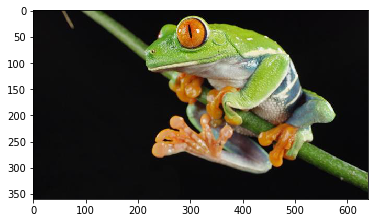

In [56]:
img = Image.open('../../sample_images/frog.jpg')
plt.imshow(img)

Always apply the same preprocessing steps

In [57]:
transform = transforms.Compose([
                                transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

Always check the shapes

In [58]:
img_preprocessed = transform(img)
print(img_preprocessed.shape)

torch.Size([3, 32, 32])


Expand the dimensions

In [59]:
img_preprocessed.unsqueeze_(0)
print(img_preprocessed.shape, img_preprocessed.dtype)

torch.Size([1, 3, 32, 32]) torch.float32


Copy to the correct device

In [60]:
img_preprocessed = img_preprocessed.to(device)

Do the prediction

In [61]:
model.eval()
output = model(img_preprocessed)
print(output)

tensor([[-0.9735, -2.3080,  1.4112,  3.1397, -0.5170,  2.2344,  4.5816, -0.9927,
         -3.4881,  0.2919]], grad_fn=<AddmmBackward>)


In [62]:
_, predicted = torch.max(output, 1)
print('Class: ', CLASSES[predicted])

Class:  frog
